##__Announcement!__ 
__[STAC metadata](https://developers.planet.com/docs/orders/delivery/#stac-metadata) in the Orders API is in Beta now. You no longer need to use PySTAC or other third-party solutions to create a STAC catalog of imagery. Instead of working your way through this article, we recommend trying out the Orders API STAC metadata. We will unpublish this Introduction to STAC Part 2 tutorial when Beta is complete.__

In this tutorial, we will highlight how to create a simple STAC catalog using the python library PySTAC. We will refer back to the catalog of items we obtained from our Planet order and the corresponding analytic assets (our COGs stored in our Google Cloud Storage bucket).

## Import Dependencies

In [1]:
import pystac
import os
import json
import requests
import urllib.request
import rasterio
from tempfile import TemporaryDirectory
from pathlib import Path
import typing

## Create Empty STAC Catalog

Get the STAC version pystac defaults to

In [2]:
pystac.get_stac_version()

'1.0.0-beta.2'

In [3]:
catalog = pystac.Catalog(id='sample-catalog', description='Simple STAC catalog.')

In [4]:
catalog

<Catalog id=sample-catalog>

Our catalog is currently empty. Let's go ahead and add some items to it.

In [5]:
print(list(catalog.get_all_items()))
print(list(catalog.get_children()))

[]
[]


## Creating STAC Items from a Planet Order

### Setup Planet Authentication

In [6]:
import requests
from requests.auth import HTTPBasicAuth
import json

## Get Planet API key stored as an environment variable on your system
PLANET_API_KEY = os.getenv('PLANET_API_KEY')

## HTTP Basic Authentication
planet_auth = HTTPBasicAuth(PLANET_API_KEY, '')

# set content type to json
headers = {'content-type': 'application/json'}

In [7]:
# Base Order URL
planet_orders_url = 'https://api.planet.com/compute/ops/orders/v2'

# order id
order_id = 'cb363b75-b4e4-46f1-8d32-0ef87afb6215'

List containing some of the item ids from our order

In [8]:
item_ids = [
         '20210515_145754_03_245c',
         '20210514_145807_70_2455',
]

### Downloading and Storing Planet Order Metadata.json for the Items

In [9]:
def store_item_metadata(order_id, metadata_folder_name, item_type, item_ids):
   
    # Get previous Planet order results with the order id associated with the order
    current_order = planet_orders_url + '/' + order_id
    order_response = requests.get(current_order, auth=planet_auth)
    order_response.status_code
    order_results = order_response.json()['_links']['results']
 

    # List of metadata json file names from the selected items from the order
    file_names = [file_name := order_id + '/' +  item_type + '/' + item_id + '_metadata.json' for item_id in item_ids]

    
    # Create folder to store metadata if the folder does not already exist
    metadata_folder = Path.cwd() / metadata_folder_name
    try:
        metadata_folder.mkdir(parents=True, exist_ok=False)
    except FileExistsError as err:
        print("Directory already exists")
    
    file_paths = []
    for result in order_results:
        if result['name'] in file_names:
            json_file = result['location']
            metadata_path = Path.joinpath(metadata_folder).joinpath(result["name"])   
            file_paths.append(str(metadata_path))
            metadata_path.parent.mkdir(parents=True, exist_ok=True)
            item_metadata_download = requests.get(json_file, allow_redirects=True)
            open(metadata_path, 'wb').write(item_metadata_download.content)

In [10]:
def load_item_metadata(file):
    with open(file, "r") as f:
        data = json.load(f)
        return data

### Functionality for Creating STAC Items

In order to generate PySTAC items, we will use the rasterio and shapely to extract each item's bounding box and geometry. We will also refer to each item's metadata.json file delivered from our previous Planet order to apply some additional item properties that are not part of the core STAC Item specification but often widely used.

The resources below provide a great breakdown of common metadata fields and extensions to the core STAC specification that are available to us. 

https://github.com/radiantearth/stac-spec/tree/master/extensions

https://github.com/radiantearth/stac-spec/blob/master/item-spec/common-metadata.md

In [11]:
from rasterio.warp import calculate_default_transform
from shapely.geometry import Polygon, mapping
from datetime import datetime
from itertools import islice

def create_STAC_Item(tiff_path, metadata_json):

    with rasterio.open(tiff_path) as sample_cog:
        
        bounds = sample_cog.bounds
        src_crs = sample_cog.crs
        dst_crs = 'EPSG:4326'  # EPSG identifier for WGS84 coordinate system used by the geojson format
        
        left, bottom, right, top = rasterio.warp.transform_bounds(sample_cog.crs, dst_crs, *bounds)
        bbox = [left, bottom, right, top]
        
        # Create geojson feature
        geom = mapping(Polygon([
          [left, bottom],
           [left, top],
           [right, top],
           [right, bottom]
        ]))
        
        time_acquired = datetime.strptime(metadata_json["properties"]["acquired"][:-1], '%Y-%m-%dT%H:%M:%S.%f')
        
        # Instantiate pystac item
        item = pystac.Item(id=metadata_json["id"],
                 geometry=geom,
                 bbox=bbox,
                 datetime = time_acquired,
                 properties={
                 })

        # Use Planet metadata.json to add some common metadata to the STAC item
        metadata_properties = metadata_json["properties"]

        # Enable item extensions
        item.ext.enable('eo')
        item.ext.enable('view') 
        item.ext.enable('projection')
        
        for key, value in islice(metadata_properties.items(), 1, None):

            # Add some common metadata for the item not included in the core item specification
            if(key == 'gsd'):
                item.common_metadata.gsd = value
            
            # View Geometry Extension 
            if (key == 'sun_azimuth'):
                item.ext.view.sun_azimuth = value
            if (key == 'sun_elevation'):
                item.ext.view.sun_elevation = value
            
            # Electro Optical Extension - 
            if(key == 'cloud_cover'):
                item.ext.eo.cloud_cover = value
           
           # Projection Extension
            if(key == 'epsg_code'):
                item.ext.projection.epsg = value

        # Tuple containing spatial and temporal extent information to use later in this tutorial
        item_extent_info =  (bbox, geom, time_acquired)
     
    # Returns a list containing the PySTAC Item object and a tuple 
    # holding the bounding box, geojson polygon, and date the item was acquired
    return item, (item_extent_info)

Let's create our set of STAC Items from the Planet order metadata.json files and set the asset types to be the COGs stored in our Google Cloud Storage Bucket. 

In [12]:
def create_STAC_Items(metadata_folder_name, planet_order_id, item_type, item_ids, storage_bucket_name):

    # Store metadata 
    store_item_metadata(order_id, metadata_folder_name, item_type , item_ids)
    metadata_directory = metadata_folder_name + '/' + order_id + '/' + item_type
    metadata_files = sorted(Path(metadata_directory).glob('*'), reverse=True)

    urls = []
    urls = sorted([storage_bucket_name + item_id + '_3B_AnalyticMS.tif' for item_id in item_ids], reverse=True)

    # empty list to store STAC items
    stac_items = []
    
    for asset_url, item_metadata in zip(urls, metadata_files):
        m = load_item_metadata(item_metadata)

        item, extent = create_STAC_Item(asset_url, m)
        item.add_asset(
              key='analytic',
              asset=pystac.Asset(
                  href=asset_url,
                  title= "4-Band Analytic",
                  # indicate it is a cloud optimized geotiff
                  media_type=pystac.MediaType.COG,
                  roles=([
                    "analytic"
                  ])
              )
        ) 
        stac_items.append((item, extent))
    return stac_items

In [13]:
item_type = 'PSScene4Band'
metadata_folder = 'catalog_metadata'
storage_bucket_name = 'https://storage.googleapis.com/sample-cogs/cog/'
stac_items = create_STAC_Items(metadata_folder, order_id, item_type , item_ids, storage_bucket_name)

Directory already exists


## Add STAC Items to the STAC Catalog 

Now we can inspect the contents of our STAC Items individually and add each item to our STAC Catalog. 

In [14]:
for index, item in enumerate(stac_items):
    catalog.add_item(item[0])
    print(json.dumps(item[0].to_dict(), indent=4))

{
    "type": "Feature",
    "stac_version": "1.0.0-beta.2",
    "id": "20210515_145754_03_245c",
    "properties": {
        "eo:cloud_cover": 0,
        "proj:epsg": 32618,
        "gsd": 4.1,
        "view:sun_azimuth": 122.8,
        "view:sun_elevation": 57.3,
        "datetime": "2021-05-15T14:57:54.037986Z"
    },
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [
                    -74.43459546492133,
                    40.59496845871806
                ],
                [
                    -74.43459546492133,
                    40.8630991753778
                ],
                [
                    -73.94789184374838,
                    40.8630991753778
                ],
                [
                    -73.94789184374838,
                    40.59496845871806
                ],
                [
                    -74.43459546492133,
                    40.59496845871806
                ]
            ]
       

We can indeed verify that we have added two STAC items as children to the catalog. 

In [15]:
print(list(catalog.get_all_items()))

[<Item id=20210515_145754_03_245c>, <Item id=20210514_145807_70_2455>]


In [16]:
catalog.describe()

* <Catalog id=sample-catalog>
  * <Item id=20210515_145754_03_245c>
  * <Item id=20210514_145807_70_2455>


### Catalog Types

STAC supports the use of both relative and absolute links in json files. To provide some standard uniformity in selecting which type to use and when, the specification encourages the use of three catalog types.

<b>Self-Contained</b>

All links are relative to allow for maximum transferability. This allows a STAC catalog to be downloaded and used locally.

Links to the item assets can either be absolute links to their online locations or can be relative links to the where in the local directory they are stored.

<b>Published</b>

Published catalogs are STAC Catalogs that exist online rather than stored on a local machine.

 - <b>Absolute Published</b>

This is a published catalog that stores all links as absolute.

 - <b>Relative Published</b>

The catalog is self-contained with the exception that it contains an absolute link at the root to where it is stored online.

## Adding a Collection to Our Catalog

As mentioned earlier, a Collection is really just an extension of a STAC Catalog. It has some additional metadata like <b>spatial extent</b> and <b>temporal extent</b>. We will describe extent in detail later in this notebook. We'll create a Collection using some other COGs from our Google Cloud Storage Bucket and demonstrate how to generate one using PySTAC. This Collection will exist as a subdirectory within our already existing STAC Catalog.

### Create Additional STAC Items

In [17]:
collection_item_ids = [
        '20210513_150715_17_1067',
        '20210512_152647_0f15',
        '20210512_152646_0f15',
]
collection_metadata_folder = "collection_metadata"

In [18]:
collection_stac_items = create_STAC_Items(collection_metadata_folder, order_id, item_type , collection_item_ids, storage_bucket_name)

Directory already exists


In [19]:
for index, collection_item in enumerate(collection_stac_items):
    print(json.dumps(collection_item[0].to_dict(), indent=4))

{
    "type": "Feature",
    "stac_version": "1.0.0-beta.2",
    "id": "20210513_150715_17_1067",
    "properties": {
        "eo:cloud_cover": 0,
        "proj:epsg": 32618,
        "gsd": 3.7,
        "view:sun_azimuth": 126.1,
        "view:sun_elevation": 58.1,
        "datetime": "2021-05-13T15:07:15.171792Z"
    },
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [
                    -74.27891390114934,
                    40.687388944405484
                ],
                [
                    -74.27891390114934,
                    40.88465957427119
                ],
                [
                    -73.94518702625808,
                    40.88465957427119
                ],
                [
                    -73.94518702625808,
                    40.687388944405484
                ],
                [
                    -74.27891390114934,
                    40.687388944405484
                ]
            ]
  

### SpatialTemporal Extents of a Collection

#### Spatial Extent

One of the key things a Collection includes is the spatial extent of the items it holds. What do we mean by spatial extent?

Spatial Extent refers to the the extent of geographic space a raster covers. This is represented by the four corners of a raster image ( xmin, y min, x max, y max).

Since we are items into our collection, we will need to determine the full extent of geographic space both items cover when combined. To do this, we will need to find the union of the items geojson polygons and merge them into one polygon.

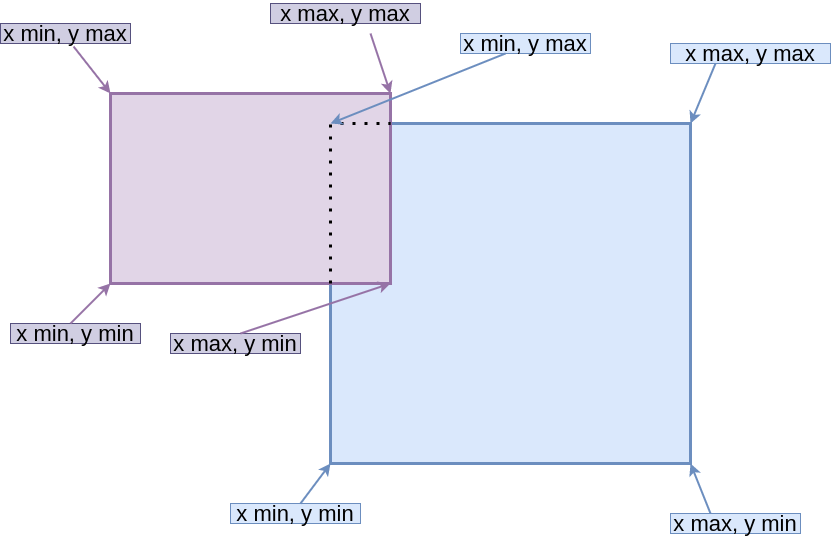

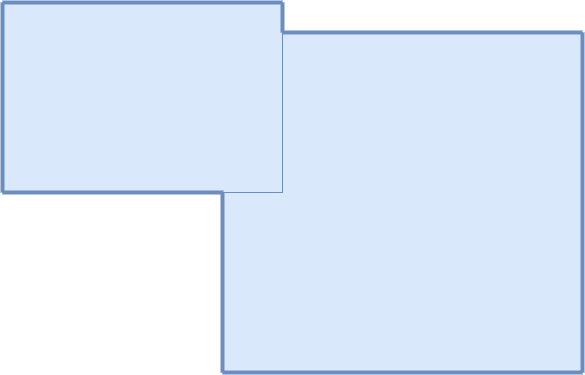

In [20]:
from shapely.ops import unary_union
import matplotlib.pyplot as plt 
from shapely.geometry import shape

def get_spatial_extent(polygons):
    
    # Plot of polygons overlay
    plt.figure(figsize=(14, 8))
    for polygon in polygons:
        plt.plot(*shape(polygon).exterior.xy)

    # Returns a union of the two geojson polygons for each item
    unioned_geometry = unary_union(polygons)

    # Plot the unified polygon
    x, y = shape(unioned_geometry).exterior.xy
    plt.figure(figsize=(14,8))
    plt.fill(x, y, alpha=0.5, facecolor='none', edgecolor='purple', linewidth=7)
    plt.show()
    
    # Set the bbox to be the bounds of the unified polygon and return the spatial extent of the collection
    return pystac.SpatialExtent(bboxes=[unioned_geometry.bounds])

#### Temporal Extent

The other type of extent that is important to a Collection is Temporal Extent.

Temporal Extent refers to the extent of time over which items in the Collection were acquired from a start date to an end date.

In [21]:
def get_temporal_extent(startime, endtime):
    time_interval = [startime, endtime]
    temporal_extent = pystac.TemporalExtent(intervals=[time_interval])
    return temporal_extent

### Combining Spatial and Temporal Extent to Create Full Extent of the Collection

In [22]:
def create_full_extent(stac_item_list):
    polygons = []
    datetimes = []
    
    for index, stac_item in enumerate(stac_item_list):
        geometry = stac_item[1][1]
        polygons.append(shape(geometry))
        datetime = stac_item[1][2]
        datetimes.append(datetime)
        
    # Get the spatial extent
    spatial_extent = get_spatial_extent(polygons)
    
    # Get temporal extent
    temporal_extent = get_temporal_extent(min(datetimes), max(datetimes))
    collection_extent = pystac.Extent(spatial=spatial_extent, temporal=temporal_extent)
    
    return collection_extent

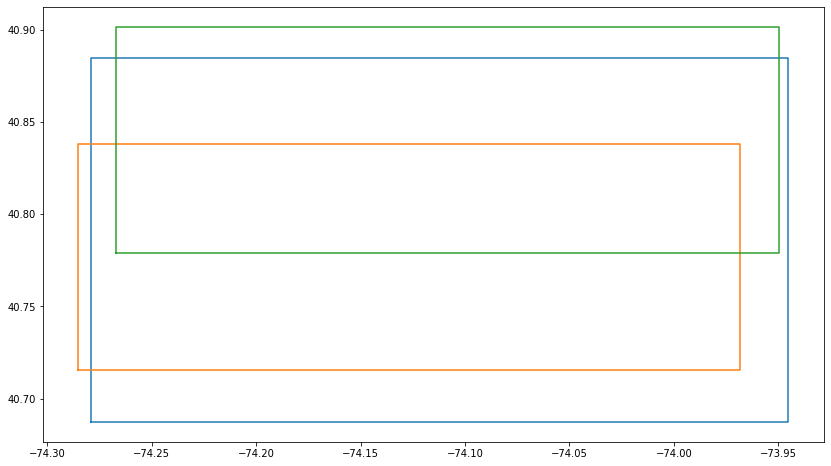

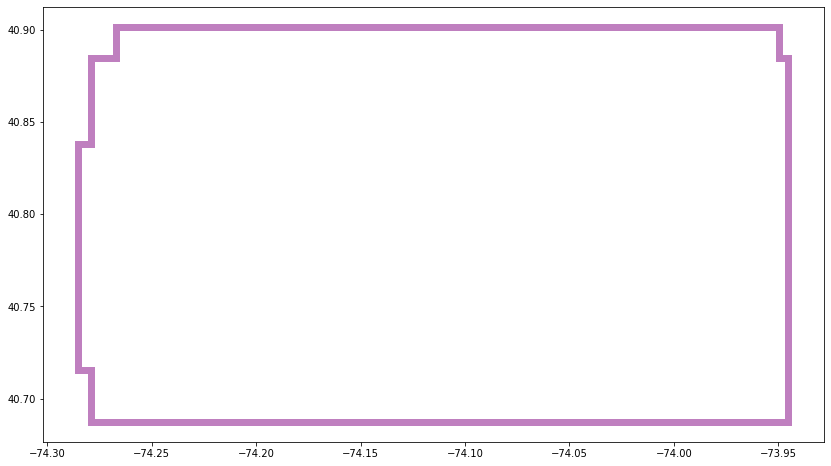

In [23]:
extent = create_full_extent(collection_stac_items)

### Create the Collection, Add STAC Items, and Set the Collection as a Child to the Catalog

In [24]:
collection = pystac.Collection(id='nyc-images',
                               description='Planet PSScene4Band Analytic Images Over Midtown Manhattan',
                               extent=extent,
                               license='test')

In [25]:
collection.providers = [
    pystac.Provider(name='Planet', roles=['producer', 'processor'], url='https://www.planet.com')
]

In [26]:
collection_items =[collection_stac_item[0] for collection_stac_item in collection_stac_items]
collection.add_items(collection_items)

In [27]:
collection.describe()

* <Collection id=nyc-images>
  * <Item id=20210513_150715_17_1067>
  * <Item id=20210512_152647_0f15>
  * <Item id=20210512_152646_0f15>


In [28]:
catalog.add_child(collection)

### Normalize HREFS and Save Catalog

We'll setup a temporary directory that will serve as the entry point for our STAC Catalog.The HREFs for all STAC links are structured according to the location of the root catalog. For the purpose of this tutorial, we are creating a self-contained catalog. Asset links will be absolute to reference the location of our COGs online. Feel free to adjust to your own use case.

In [29]:
tmp_dir = TemporaryDirectory()
root_path = str(Path(tmp_dir.name).joinpath('sample-stac'))
catalog.normalize_and_save(root_href = root_path, 
                         catalog_type=pystac.CatalogType.SELF_CONTAINED)

## Here is Our Simple STAC Created with Planet Imagery!

Now we can see our entire sample Planet STAC in action!

If we look below, we can see our outermost root catalog linking to the STAC Items we created at the start of this tutorial followed by our newly created STAC Collection containing three other STAC Items. 

In [30]:
catalog.describe()

* <Catalog id=sample-catalog>
    * <Collection id=nyc-images>
      * <Item id=20210513_150715_17_1067>
      * <Item id=20210512_152647_0f15>
      * <Item id=20210512_152646_0f15>
  * <Item id=20210515_145754_03_245c>
  * <Item id=20210514_145807_70_2455>


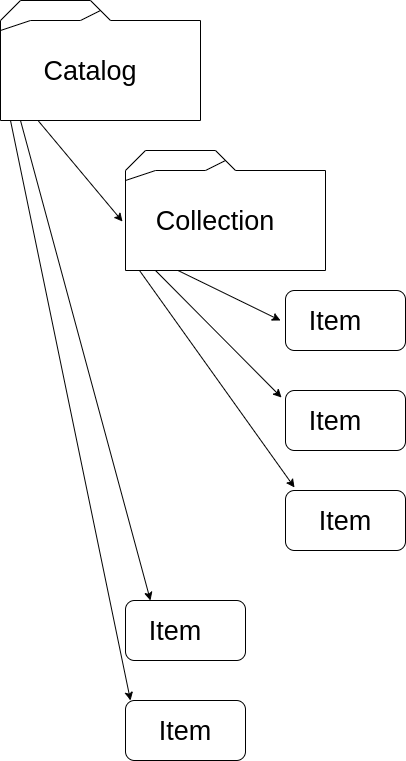

And if we open our catalog.json document, we can see the root self-referencing relative link, the relative link to the two STAC items within the catalog and the relative link to the Collection.json file childed to it.

In [31]:
with open(catalog.get_self_href()) as f:
    print(f.read())

{
    "id": "sample-catalog",
    "stac_version": "1.0.0-beta.2",
    "description": "Simple STAC catalog.",
    "links": [
        {
            "rel": "root",
            "href": "./catalog.json",
            "type": "application/json"
        },
        {
            "rel": "item",
            "href": "./20210515_145754_03_245c/20210515_145754_03_245c.json",
            "type": "application/json"
        },
        {
            "rel": "item",
            "href": "./20210514_145807_70_2455/20210514_145807_70_2455.json",
            "type": "application/json"
        },
        {
            "rel": "child",
            "href": "./nyc-images/collection.json",
            "type": "application/json"
        }
    ]
}


And here is our collection.json that is a child to our root catalog.

In [32]:
with open(collection.get_self_href()) as f:
    print(f.read())

{
    "id": "nyc-images",
    "stac_version": "1.0.0-beta.2",
    "description": "Planet PSScene4Band Analytic Images Over Midtown Manhattan",
    "links": [
        {
            "rel": "root",
            "href": "../catalog.json",
            "type": "application/json"
        },
        {
            "rel": "item",
            "href": "./20210513_150715_17_1067/20210513_150715_17_1067.json",
            "type": "application/json"
        },
        {
            "rel": "item",
            "href": "./20210512_152647_0f15/20210512_152647_0f15.json",
            "type": "application/json"
        },
        {
            "rel": "item",
            "href": "./20210512_152646_0f15/20210512_152646_0f15.json",
            "type": "application/json"
        },
        {
            "rel": "parent",
            "href": "../catalog.json",
            "type": "application/json"
        }
    ],
    "extent": {
        "spatial": {
            "bbox": [
                [
                    -7

## STAC Validation

### Using STAC Validator

One option to validate our STAC is to use the STACValidator python utility. We can see that every json file in our STAC meet the criteria for a valid STAC entity.

In [33]:
from stac_validator import stac_validator

# Instantiate a STACValidate Object. Setting recursive to -1 will do a full recursive validation 
# for the STAC catalog
stac = stac_validator.StacValidate(catalog.get_self_href(), recursive=-1)
stac.run()
validation_check = [message for message in stac.message]
validation_check

[{'version': '1.0.0-beta.2',
  'path': '/tmp/tmp4cqko1fi/sample-stac/catalog.json',
  'schema': ['https://schemas.stacspec.org/v1.0.0-beta.2/catalog-spec/json-schema/catalog.json'],
  'valid_stac': True,
  'asset_type': 'CATALOG',
  'validation_method': 'recursive'},
 {'version': '1.0.0-beta.2',
  'path': '/tmp/tmp4cqko1fi/sample-stac/./20210515_145754_03_245c/20210515_145754_03_245c.json',
  'schema': ['https://cdn.staclint.com/v1.0.0-beta.1/extension/eo.json',
   'https://cdn.staclint.com/v1.0.0-beta.1/extension/view.json',
   'https://cdn.staclint.com/v1.0.0-beta.1/extension/projection.json',
   'https://schemas.stacspec.org/v1.0.0-beta.2/item-spec/json-schema/item.json'],
  'valid_stac': True,
  'asset_type': 'ITEM',
  'validation_method': 'recursive'},
 {'version': '1.0.0-beta.1',
  'path': '/tmp/tmp4cqko1fi/sample-stac/./20210514_145807_70_2455/20210514_145807_70_2455.json',
  'schema': ['https://cdn.staclint.com/v1.0.0-beta.1/extension/eo.json',
   'https://cdn.staclint.com/v1.0

### Using PySTAC

We can also walk over the STAC by using the Catalog.walk() method in PySTAC. The output below shows that there are no validation errors.

In [34]:
for root, subcategories, items in catalog.walk():

    print('{} is the current root in the STAC'.format(root.id))
    print('Are there any any STAC validation errors ?: {}'.format(root.validate()))
    
    for subcat in subcategories:
        print('{} is a subcatalog or collection for the current root in the STAC'.format(subcat.id))
        print('Are there any STAC validation errors ?: {}'.format(subcat.validate()))
        
    for item in items:
        print('{} is a STAC Item within the current root'.format(item.id))
        print('Are there any STAC validation errors ?: {}'.format(item.validate()))

sample-catalog is the current root in the STAC
Are there any any STAC validation errors ?: None
nyc-images is a subcatalog or collection for the current root in the STAC
Are there any STAC validation errors ?: None
20210515_145754_03_245c is a STAC Item within the current root
Are there any STAC validation errors ?: None
20210514_145807_70_2455 is a STAC Item within the current root
Are there any STAC validation errors ?: None
nyc-images is the current root in the STAC
Are there any any STAC validation errors ?: None
20210513_150715_17_1067 is a STAC Item within the current root
Are there any STAC validation errors ?: None
20210512_152647_0f15 is a STAC Item within the current root
Are there any STAC validation errors ?: None
20210512_152646_0f15 is a STAC Item within the current root
Are there any STAC validation errors ?: None


#### Clear Catalog and Cleanup Temporary Directory

In [35]:
catalog.clear_children()
catalog.clear_items()
list(catalog.get_children())

[]

In [36]:
list(catalog.get_items())

[]

In [37]:
tmp_dir.cleanup()